# Standard Imports

In [536]:
import pandas as pd
import numpy as np
import unicodedata
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import time, math
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from string import punctuation
import unidecode
import re
from sklearn.metrics import make_scorer
from nltk.corpus import stopwords
import os

## Import data + data types analysis

In [537]:
train_df = pd.read_csv('data/drugs_train.csv')
test_df = pd.read_csv('data/drugs_test.csv')

# Auxiliary data
active_ingredients = pd.read_csv('data/active_ingredients.csv')
drug_label_feature_eng = pd.read_csv('data/drug_label_feature_eng.csv')

train_df.shape, test_df.shape, active_ingredients.shape, drug_label_feature_eng.shape

((8564, 14), (3671, 13), (19847, 2), (3010, 28))

In [538]:
train_df.head()

,drug_id,description,administrative_status,marketing_status,approved_for_hospital_use,reimbursement_rate,dosage_form,route_of_administration,marketing_authorization_status,marketing_declaration_date,marketing_authorization_date,marketing_authorization_process,pharmaceutical_companies,price
0,0_train,3 plaquette(s) thermoformée(s) PVC-Aluminium d...,Présentation active,Déclaration de commercialisation,oui,65%,comprimé pelliculé,orale,Autorisation active,20140101,20140101,Procédure décentralisée,MAJORELLE LUXEMBOURG SOPARFI (LUXEMBOURG),2.83
1,1_train,plaquette(s) thermoformée(s) aluminium de 28 c...,Présentation active,Déclaration de commercialisation,oui,65%,comprimé à croquer,orale,Autorisation active,20130101,20090101,Procédure de reconnaissance mutuelle,TEVA SANTE,14.30
2,2_train,plaquette(s) thermoformée(s) PVC-aluminium de ...,Présentation active,Déclaration de commercialisation,oui,65%,gélule à libération prolongée,orale,Autorisation active,20000101,19960101,Procédure nationale,MYLAN SAS,5.66
3,3_train,30 sachet(s)-dose(s) papier aluminium complexe...,Présentation active,Déclaration de commercialisation,oui,65%,granulés à libération prolongée,orale,Autorisation active,20050101,20040101,Procédure nationale,SANOFI AVENTIS FRANCE,24.27
4,4_train,plaquette(s) thermoformée(s) PVC-Aluminium de ...,Présentation active,Déclaration d'arrêt de commercialisation,non,100%,comprimé pelliculé,orale,Autorisation active,20150101,20100101,Procédure nationale,TEVA SANTE,59.94


In [539]:
test_df.head()

,drug_id,description,administrative_status,marketing_status,approved_for_hospital_use,reimbursement_rate,dosage_form,route_of_administration,marketing_authorization_status,marketing_declaration_date,marketing_authorization_date,marketing_authorization_process,pharmaceutical_companies
0,0_test,plaquette(s) thermoformée(s) polyamide alumini...,Présentation active,Déclaration d'arrêt de commercialisation,non,65%,comprimé gastro-résistant(e),orale,Autorisation active,20130101,20080101,Procédure de reconnaissance mutuelle,TEVA SANTE
1,1_test,plaquette(s) thermoformée(s) PVC PVDC aluminiu...,Présentation active,Déclaration de commercialisation,non,30%,capsule,vaginale,Autorisation active,20120101,19970101,Procédure nationale,INNOTECH INTERNATIONAL
2,2_test,plaquette(s) thermoformée(s) PVC-Aluminium de ...,Présentation active,Déclaration d'arrêt de commercialisation,non,65%,comprimé,orale,Autorisation abrogée,20130101,20060101,Procédure nationale,ACTAVIS FRANCE
3,3_test,5 cartouche(s) en verre de 3 ml dans stylo pré...,Présentation active,Déclaration d'arrêt de commercialisation,non,65%,suspension injectable,sous-cutanée,Autorisation active,20120101,20000101,Procédure centralisée,SANOFI AVENTIS (ALLEMAGNE)
4,4_test,5 poche(s) à 3 compartiments polyamide polypro...,Présentation active,Déclaration de commercialisation,oui,65%,émulsion pour perfusion,intraveineuse,Autorisation active,20110101,20110101,Procédure décentralisée,B BRAUN MELSUNGEN


The active ingredients dataframe contains text features describing the active compound in each drug. We can add it to the main train and test data frame to enrich our set of features.

In [540]:
active_ingredients['drug_id']
train_index = train_df['drug_id'].values
test_index = test_df['drug_id'].values

dict_ingredients_train = {k: active_ingredients[active_ingredients.drug_id==k]['active_ingredient'].values[0] for k in train_index}
dict_ingredients_test = {k: active_ingredients[active_ingredients.drug_id==k]['active_ingredient'].values[0] for k in test_index}

We add a new column 'active_ingredient' to the train and test dataframes.

In [541]:
train_df['active_ingredient'] = train_df['drug_id'].map(dict_ingredients_train)
test_df['active_ingredient'] = test_df['drug_id'].map(dict_ingredients_test)

In [542]:
train_df.head()

,drug_id,description,administrative_status,marketing_status,approved_for_hospital_use,reimbursement_rate,dosage_form,route_of_administration,marketing_authorization_status,marketing_declaration_date,marketing_authorization_date,marketing_authorization_process,pharmaceutical_companies,price,active_ingredient
0,0_train,3 plaquette(s) thermoformée(s) PVC-Aluminium d...,Présentation active,Déclaration de commercialisation,oui,65%,comprimé pelliculé,orale,Autorisation active,20140101,20140101,Procédure décentralisée,MAJORELLE LUXEMBOURG SOPARFI (LUXEMBOURG),2.83,DÉSOGESTREL
1,1_train,plaquette(s) thermoformée(s) aluminium de 28 c...,Présentation active,Déclaration de commercialisation,oui,65%,comprimé à croquer,orale,Autorisation active,20130101,20090101,Procédure de reconnaissance mutuelle,TEVA SANTE,14.30,MONTÉLUKAST ACIDE
2,2_train,plaquette(s) thermoformée(s) PVC-aluminium de ...,Présentation active,Déclaration de commercialisation,oui,65%,gélule à libération prolongée,orale,Autorisation active,20000101,19960101,Procédure nationale,MYLAN SAS,5.66,CHLORHYDRATE DE DILTIAZEM
3,3_train,30 sachet(s)-dose(s) papier aluminium complexe...,Présentation active,Déclaration de commercialisation,oui,65%,granulés à libération prolongée,orale,Autorisation active,20050101,20040101,Procédure nationale,SANOFI AVENTIS FRANCE,24.27,ACIDE VALPROÏQUE
4,4_train,plaquette(s) thermoformée(s) PVC-Aluminium de ...,Présentation active,Déclaration d'arrêt de commercialisation,non,100%,comprimé pelliculé,orale,Autorisation active,20150101,20100101,Procédure nationale,TEVA SANTE,59.94,LÉTROZOLE


Checking the presence of missing values for each feature in the training set

In [543]:
for col in train_df.columns.values:
    df_missing_values = train_df[col].isnull().astype(int)
    print("There are {} % of missing values in the column {}".format(int(df_missing_values.mean())*100,
                                                                     col))

There are 0 % of missing values in the column drug_id
There are 0 % of missing values in the column description
There are 0 % of missing values in the column administrative_status
There are 0 % of missing values in the column marketing_status
There are 0 % of missing values in the column approved_for_hospital_use
There are 0 % of missing values in the column reimbursement_rate
There are 0 % of missing values in the column dosage_form
There are 0 % of missing values in the column route_of_administration
There are 0 % of missing values in the column marketing_authorization_status
There are 0 % of missing values in the column marketing_declaration_date
There are 0 % of missing values in the column marketing_authorization_date
There are 0 % of missing values in the column marketing_authorization_process
There are 0 % of missing values in the column pharmaceutical_companies
There are 0 % of missing values in the column price
There are 0 % of missing values in the column active_ingredient


Checking the presence of missing values for each feature in the test set

In [544]:
for col in test_df.columns.values:
    df_missing_values = test_df[col].isnull().astype(int)
    print("There are {} % of missing values in the column {}".format(int(df_missing_values.mean())*100,
                                                                     col))

There are 0 % of missing values in the column drug_id
There are 0 % of missing values in the column description
There are 0 % of missing values in the column administrative_status
There are 0 % of missing values in the column marketing_status
There are 0 % of missing values in the column approved_for_hospital_use
There are 0 % of missing values in the column reimbursement_rate
There are 0 % of missing values in the column dosage_form
There are 0 % of missing values in the column route_of_administration
There are 0 % of missing values in the column marketing_authorization_status
There are 0 % of missing values in the column marketing_declaration_date
There are 0 % of missing values in the column marketing_authorization_date
There are 0 % of missing values in the column marketing_authorization_process
There are 0 % of missing values in the column pharmaceutical_companies
There are 0 % of missing values in the column active_ingredient


**There are no missing values in the dataframe**

let's take a look at the types encountered in the Dataframe

In [545]:
train_df.dtypes

drug_id                             object
description                         object
administrative_status               object
marketing_status                    object
approved_for_hospital_use           object
reimbursement_rate                  object
dosage_form                         object
route_of_administration             object
marketing_authorization_status      object
marketing_declaration_date           int64
marketing_authorization_date         int64
marketing_authorization_process     object
pharmaceutical_companies            object
price                              float64
active_ingredient                   object
dtype: object

Let's look at the number of unique values in the dataframe for each column

In [546]:
for col in train_df.columns:
    x = train_df[col].unique()
    len_x = len(train_df[col].unique())
    print("Feature: {} | number of unique elements: {} \n".format(col, len_x))

Feature: drug_id | number of unique elements: 8564 

Feature: description | number of unique elements: 2575 

Feature: administrative_status | number of unique elements: 2 

Feature: marketing_status | number of unique elements: 4 

Feature: approved_for_hospital_use | number of unique elements: 2 

Feature: reimbursement_rate | number of unique elements: 5 

Feature: dosage_form | number of unique elements: 190 

Feature: route_of_administration | number of unique elements: 75 

Feature: marketing_authorization_status | number of unique elements: 4 

Feature: marketing_declaration_date | number of unique elements: 80 

Feature: marketing_authorization_date | number of unique elements: 40 

Feature: marketing_authorization_process | number of unique elements: 5 

Feature: pharmaceutical_companies | number of unique elements: 325 

Feature: price | number of unique elements: 1812 

Feature: active_ingredient | number of unique elements: 1283 



# Feature analysis

**Normalize all strings in dataset**

In [547]:
for i in list(train_df.select_dtypes(include=['object'])):
    #convert all strings to lowercase and remove all accents
    train_df[i] = train_df[i].str.lower().map(lambda x: unicodedata.normalize('NFKD', x))
    test_df[i] = test_df[i].str.lower().map(lambda x: unicodedata.normalize('NFKD', x))

3 types of features in the dataset:
- Text features
- binary features
- ordinal features
- categorical features

In [548]:
text_features = ['description', 'dosage_form', 'pharmaceutical_companies',
                 'route_of_administration', 'active_ingredient']

feat_categorical = ['marketing_authorization_status', 'marketing_authorization_process',
                    'marketing_status']

feat_binary = ['approved_for_hospital_use', 'administrative_status']

feat_ordinal = ["reimbursement_rate"]

## Feature engineering

**Distribution of Price**

<AxesSubplot:>

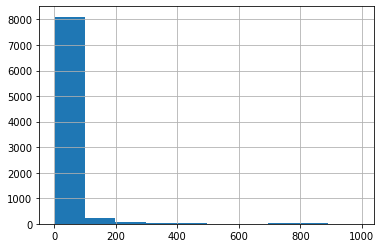

In [549]:
train_df['price'].hist()

**Distribution of price in logscale**

//anaconda3/envs/manomano/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    8564.000000
mean        2.279071
std         1.271988
min        -0.510826
25%         1.371181
50%         2.071913
75%         3.002211
max         6.898099
Name: logprice, dtype: float64


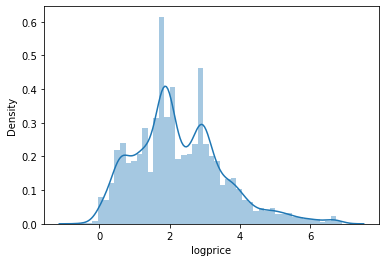

In [550]:
# Distribution du log des prix
train_df['logprice'] = train_df['price'].apply(np.log)
#train['logprix'].hist()
sns.distplot(train_df['logprice'])
print(train_df['logprice'].describe())

The distribution of the 'logprice' is gaussian-like and bimodal.

**Encoding Date features**

In [551]:
# TRAINING SET
train_df['marketing_declaration_date'] = train_df['marketing_declaration_date'].apply(lambda x: str(x)[:4]).astype(int)
train_df['marketing_authorization_date'] = train_df['marketing_authorization_date'].apply(lambda x: str(x)[:4]).astype(int)

In [552]:
# TEST SET
test_df['marketing_declaration_date'] = test_df['marketing_declaration_date'].apply(lambda x: str(x)[:4]).astype(int)
test_df['marketing_authorization_date'] = test_df['marketing_authorization_date'].apply(lambda x: str(x)[:4]).astype(int)

In [553]:
train_df['approved_for_hospital_use']

0       oui
1       oui
2       oui
3       oui
4       non
       ... 
8559    non
8560    oui
8561    non
8562    oui
8563    oui
Name: approved_for_hospital_use, Length: 8564, dtype: object

In [554]:
feat_binary

['approved_for_hospital_use', 'administrative_status']

**Encoding Binary variables**

In [555]:
replace_dict = {'présentation abrogée': 0, 'présentation active': 1,
                'non': 0, 'oui': 1,
               }

for column in feat_binary:
    train_df.loc[:, column] = train_df.loc[:, column].replace(replace_dict)
    test_df.loc[:, column] = test_df.loc[:, column].replace(replace_dict)

**Encoding Ordinal variables (Reimbursement rate)**

<AxesSubplot:xlabel='reimbursement_rate', ylabel='count'>

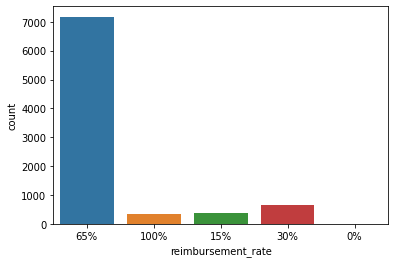

In [556]:
sns.countplot(x="reimbursement_rate", data=train_df)

In [557]:
rates = sorted([int(x.strip('%')) for x in train_df['reimbursement_rate'].unique()])
rates = [str(x)+'%' for x in rates]
replace_dict = {i: j for i, j in zip(rates, range(len(rates)))}

for column in feat_ordinal:
    train_df.loc[:, column] = train_df.loc[:, column].replace(replace_dict)
    test_df.loc[:, column] = test_df.loc[:, column].replace(replace_dict)

In [558]:
train_df.head()

,drug_id,description,administrative_status,marketing_status,approved_for_hospital_use,reimbursement_rate,dosage_form,route_of_administration,marketing_authorization_status,marketing_declaration_date,marketing_authorization_date,marketing_authorization_process,pharmaceutical_companies,price,active_ingredient,logprice
0,0_train,3 plaquette(s) thermoformée(s) pvc-aluminium ...,1,déclaration de commercialisation,1,3,comprimé pelliculé,orale,autorisation active,2014,2014,procédure décentralisée,majorelle luxembourg soparfi (luxembourg),2.83,désogestrel,1.040277
1,1_train,plaquette(s) thermoformée(s) aluminium de 28 ...,1,déclaration de commercialisation,1,3,comprimé à croquer,orale,autorisation active,2013,2009,procédure de reconnaissance mutuelle,teva sante,14.30,montélukast acide,2.660260
2,2_train,plaquette(s) thermoformée(s) pvc-aluminium de...,1,déclaration de commercialisation,1,3,gélule à libération prolongée,orale,autorisation active,2000,1996,procédure nationale,mylan sas,5.66,chlorhydrate de diltiazem,1.733424
3,3_train,30 sachet(s)-dose(s) papier aluminium complexe...,1,déclaration de commercialisation,1,3,granulés à libération prolongée,orale,autorisation active,2005,2004,procédure nationale,sanofi aventis france,24.27,acide valproïque,3.189241
4,4_train,plaquette(s) thermoformée(s) pvc-aluminium de...,1,déclaration d'arrêt de commercialisation,0,4,comprimé pelliculé,orale,autorisation active,2015,2010,procédure nationale,teva sante,59.94,létrozole,4.093344


### Pairwise feature correlation

***Scatter plot***

We can notice a positive linear association between the marketing declaration date/marketing authorization date and the target price

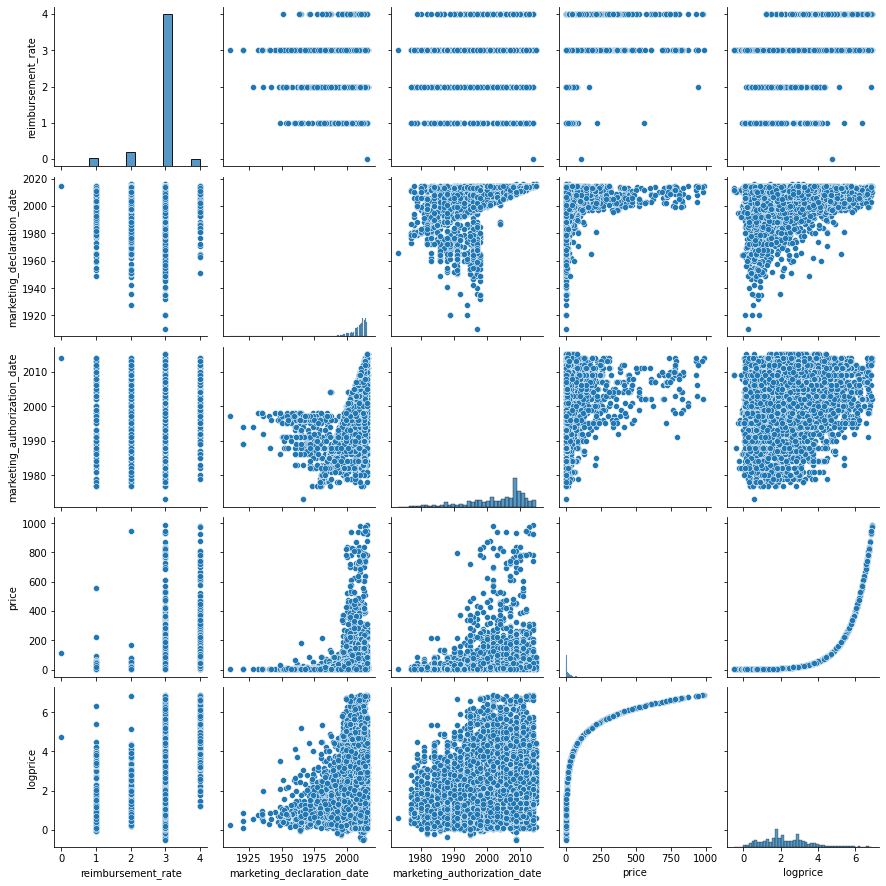

In [559]:
sns.pairplot(train_df.drop(text_features + feat_binary, axis = 1))

***Correlation matrix***

We can compute the spearman correlation for each pair of feature to confirm the intuition (spearman correlation ~= 0.4)

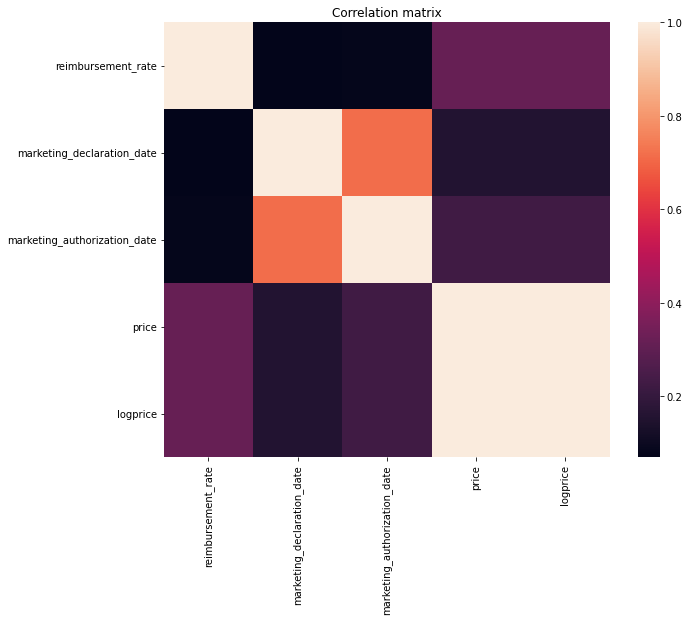

In [560]:
f, ax = plt.subplots(figsize=(10, 8))
df =  train_df.drop(text_features + feat_binary, axis = 1)
corr = df.corr(method='spearman')
sns.heatmap(corr,
            ax=ax
           )
plt.title('Correlation matrix')
plt.show()

***Correlation between features and target variable (logprice)***

Logprice / marketing declaration date

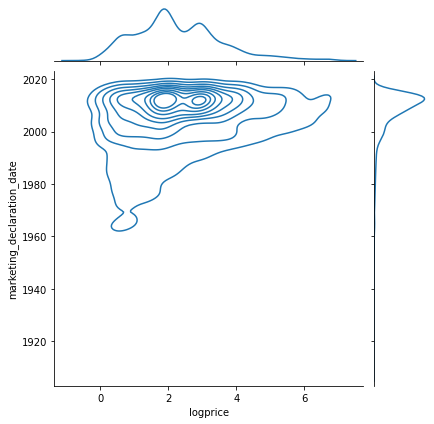

In [561]:
sns.jointplot(x="logprice",
              y="marketing_declaration_date",
              data=train_df,
              kind="kde"
             )

Logprice / marketing authorization date

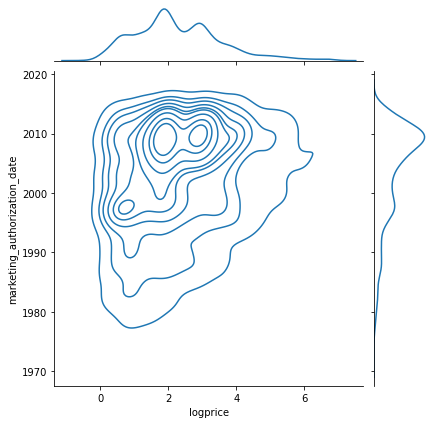

In [562]:
sns.jointplot(x="logprice",
              y="marketing_authorization_date",
              data=train_df,
              kind="kde"
             )

Logprice / reimbursement rate

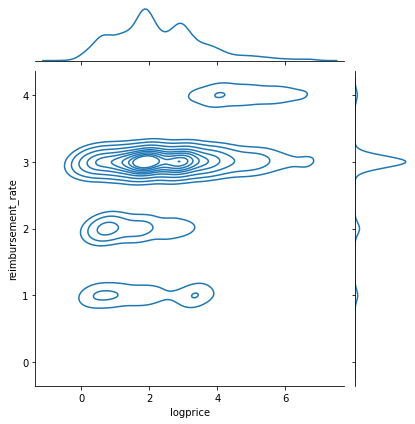

In [563]:
sns.jointplot(x="logprice",
              y="reimbursement_rate",
              data=train_df,
              kind="kde"
             )

**Categorical Features**

In [564]:
def one_hot_encode_categorical(train_df, test_df, cols, replace=False):
    vectorizer = DictVectorizer()
    mkdict = lambda row: dict((col, row[col]) for col in cols)
    total_df = train_df.append(test_df)
    vectorizer.fit(total_df[cols].apply(mkdict, axis=1))   # fit on both train and test
    # on train
    train_categorical_df = pd.DataFrame(vectorizer.transform(train_df[cols].apply(mkdict, axis=1)).toarray()).astype(int)
    train_categorical_df.columns = vectorizer.get_feature_names()
    train_categorical_df.index = train_df.index
    # on test
    test_categorical_df = pd.DataFrame(vectorizer.transform(test_df[cols].apply(mkdict, axis=1)).toarray()).astype(int)
    test_categorical_df.columns = vectorizer.get_feature_names()
    test_categorical_df.index = test_df.index
    if replace is True:
        train_df = train_df.drop(cols, axis=1)
        train_df = train_df.join(train_categorical_df)
        test_df = test_df.drop(cols, axis=1)
        test_df = test_df.join(test_categorical_df)
    return train_df, test_df, list(train_categorical_df)

In [565]:
train_df, test_df, feat_cat = one_hot_encode_categorical(train_df,
                                                         test_df,
                                                         feat_categorical,
                                                         replace=True)

//anaconda3/envs/manomano/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**Text features**

We encode each text feature [i.e description, active ingredients, pharmaceutical company, dosage form and route of administration] with a  Tfidf vectorizer followed by a PCA for dimensionality reduction.

We use Tfidf instead of BOW becasue in a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information about the actual contents of the document. tf–idf means term-frequency times inverse document-frequency. TfidfVectorizer combines all the options of CountVectorizer and TfidfTransformer in a single model

In [572]:
def preprocess_text(text):
    """
    :param: text: input text to pre-process
    :return: the pre-processed text
    """ 
    # 1. Remove punctuation and accetns from text
    text = ''.join([unidecode.unidecode(word) for word in text if word not in punctuation])
    
    # 2. Remove space
    text = re.sub(r'\s+', ' ', text)
    
    # 3. Remove parenthesis
    text = re.sub(r'[()]', '', text)

    return text

def vectorizer_text(df, feature, reduce_dimension=False):                           
    vectorizer = TfidfVectorizer(encoding='utf-8', strip_accents='ascii', lowercase=True)
    corpus = [preprocess_text(sample) for sample in df[feature].values]
    # Preprocessing
    X_tfidf = vectorizer.fit_transform(corpus).toarray()
    if reduce_dimension:
        pca = PCA(n_components=50, whiten=True)                  
        X_tfidf = pca.fit_transform(X_tfidf) 
    return X_tfidf

In [573]:
cols_text_train = []
cols_text_test = []
X_train = np.empty([train_df.shape[0], 0])
X_test = np.empty([test_df.shape[0], 0])

for feat in text_features: 
    # computes a tfidf matrix, apply PCA, for each text feature
    x_train = vectorizer_text(train_df, feat, reduce_dimension=True)
    x_test = vectorizer_text(test_df, feat, reduce_dimension=True)
    print('Dimension of tf-idf after PCA for', feat,
          ' - train:', x_train.shape, ' and test:', x_test.shape)
    # Stack features
    X_train = np.hstack((X_train, x_train))
    X_test = np.hstack((X_test, x_test))
    # creates a name for each component:    
    cols_text_train = cols_text_train + ['pca_' + feat[0:5] + '_' + str(x) for x in range(0, x_train.shape[1])]
    cols_text_test = cols_text_test + ['pca_' + feat[0:5] + '_' + str(x) for x in range(0, x_test.shape[1])]

Dimension of tf-idf after PCA for description  - train: (8564, 50)  and test: (3671, 50)
Dimension of tf-idf after PCA for dosage_form  - train: (8564, 50)  and test: (3671, 50)
Dimension of tf-idf after PCA for pharmaceutical_companies  - train: (8564, 50)  and test: (3671, 50)
Dimension of tf-idf after PCA for route_of_administration  - train: (8564, 50)  and test: (3671, 50)
Dimension of tf-idf after PCA for active_ingredient  - train: (8564, 50)  and test: (3671, 50)


Concatenate these computed features with the original dataframe

In [574]:
X_train.shape, train_df.shape, len(cols_text_train), len(cols_text_test)

((8564, 250), (8564, 27), 250, 250)

In [575]:
# creates dataframe out of Xpca_train and Xpca_train  
text_train_df = pd.DataFrame(data=X_train,
                             index=train_df.index,
                             columns=cols_text_train
                            )   
text_test_df = pd.DataFrame(data=X_test,
                            index=test_df.index,
                            columns=cols_text_test
                           )

# and join to the train and test dataset:
train_df = train_df.join(text_train_df)
test_df = test_df.join(text_test_df)

print('-' * 80)
print('Total ---', 'train:', text_train_df.shape, 'and test:', text_test_df.shape)

--------------------------------------------------------------------------------
Total --- train: (8564, 250) and test: (3671, 250)


Saving the preprocessed data.

In [580]:
train_df.shape, test_df.shape

((8564, 277), (3671, 275))

In [576]:
if not os.path.exists('data/preprocessed'):
    os.mkdir('data/preprocessed')

In [577]:
train_df.drop(text_features, axis=1).to_csv('data/preprocessed/preprocessed_drugs_train.csv')
test_df.drop(text_features, axis=1).to_csv('data/preprocessed/preprocessed_drugs_test.csv')